In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


file_dir = "./data/"

def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)

In [2]:
data_all = read_t("All", file_dir, True)
data_label = pickle.load(open(file_dir+f'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))
# print(data_all.shape)
print(data_label.shape)

nom_temp = np.arange(0.25, 4.25, 0.25)

tot_data = np.empty((0,40,40))
tot_label = np.empty(0)

for T in nom_temp :
  tmp = read_t(T, file_dir)
  tot_data = np.concatenate((tot_data, tmp.reshape(tmp.shape[0], 40, 40)))
  tot_label = np.concatenate((tot_label, T*np.ones(tmp.shape[0])))

tot_data_sym = 2*np.abs(tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1) - 0.5)
print(tot_data_sym.shape)

(160000,)
(160000,)


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym.reshape(-1,1), tot_label, test_size=0.2, random_state=42)

# Create the random forest regressor
forest_model = RandomForestRegressor(max_depth=5, bootstrap=True, n_estimators=100)

# Fit the model to the training data
forest_model.fit(X_train, y_train)

# Predict on the test data
predictions = forest_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print("mse:", mse)


mse: 0.10820422782821845


In [29]:
kde_data = pd.DataFrame({'T':tot_label, 'Sym':tot_data_sym})
kde_data = kde_data[kde_data['T'] >= 1.25]


<Axes: xlabel='Sym', ylabel='Density'>

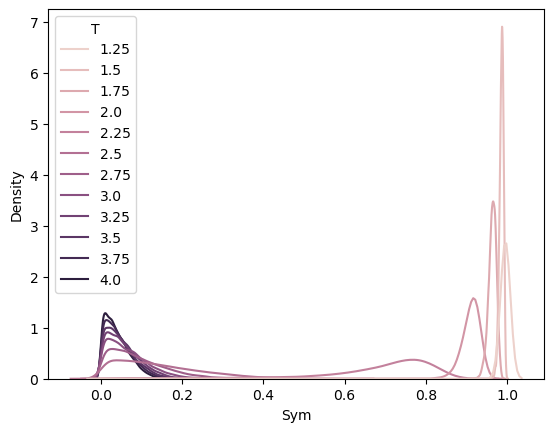

In [30]:
sns.kdeplot(data=kde_data, x="Sym", hue="T", legend=True, fill=False)

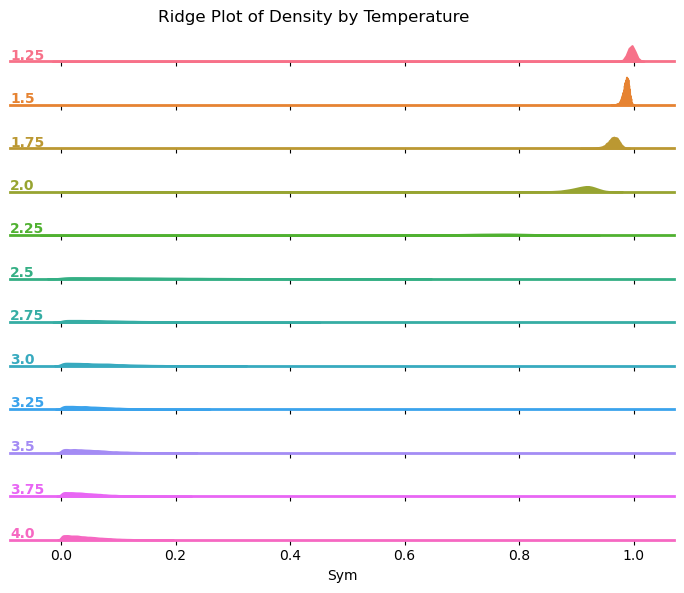

In [47]:
# Create the ridge plot
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
g = sns.FacetGrid(kde_data, row="T", hue="T", aspect=15, height=0.5)

# Draw the densities in the FacetGrid
g.map(sns.kdeplot, "Sym",
      bw_adjust=.5, clip_on=False, thresh=1,
      fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "Density", clip_on=False, color="w", lw=2, bw_adjust=.1)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Sym")

# Define the y-axis labels
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Add a title
g.fig.suptitle("Ridge Plot of Density by Temperature")

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

In [4]:
kde_data = pd.DataFrame({'T':tot_label, 'Sym':tot_data_sym})
xnew = np.linspace(0, 1, 100)
ynew = forest_model.predict(xnew.reshape(-1, 1))

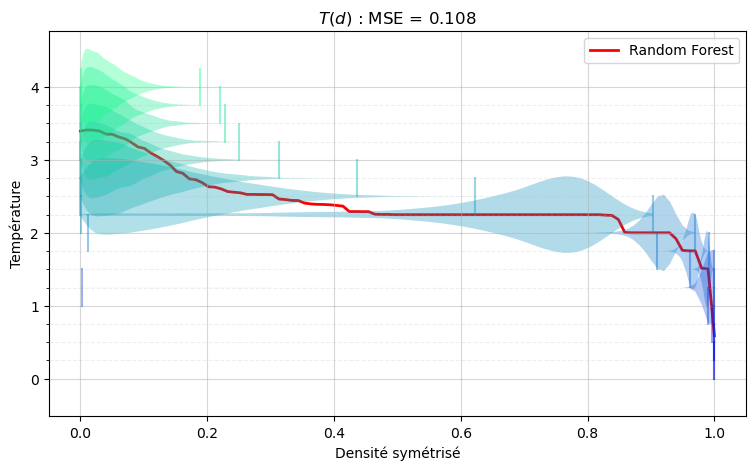

In [5]:
fig, ax = plt.subplots(figsize=(9, 5))
cmap = plt.get_cmap('winter', 16)

violinplots = []

for i in range(16):
    violinplot = ax.violinplot(
        kde_data[kde_data['T'] == nom_temp[i]]['Sym'],
        positions=[nom_temp[i]],
        showmeans=False,
        showextrema=True,
        widths=1.05,
        vert=False,
    )
    # Change colors to use cmap
    violinplot['cmaxes'].set_color(cmap(i))
    violinplot['cmins'].set_color(cmap(i))
    violinplot['cbars'].set_color(cmap(i))
    for pc in violinplot['bodies']:
        pc.set_facecolor(cmap(i))
    # Change the linewidth and alpha of the line
    violinplot['cmaxes'].set_alpha(0.4)
    violinplot['cmins'].set_alpha(0.4)
    violinplot['cbars'].set_alpha(0)
    
    violinplots.append(violinplot)

# Add the random forest line
ax.plot(xnew, ynew, color='r', linewidth=2, zorder=0, label="Random Forest")

# Create legend
ax.legend()

# Add minor ticks to the y-axis
ax.set_yticks(nom_temp, minor=True)

ax.set_xlabel("Densité symétrisé")
ax.set_ylabel("Température")
ax.set_title(f"$T(d)$ : MSE = {mse:.3f}")

# Add grid to major and minor ticks
ax.grid(which='major', alpha=0.5, zorder=-1)
ax.grid(which='minor', alpha=0.2, linestyle='--', zorder=-1)

# Save the figure
plt.savefig("forest.png")
# Display the plot
plt.show()

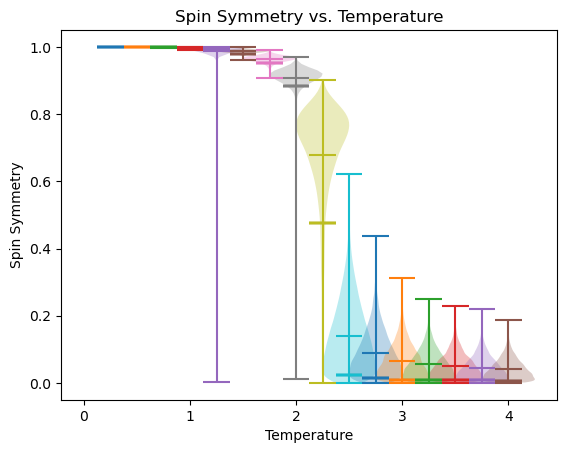

In [63]:
violinplots = []

for i in range(16):
    violinplot = plt.violinplot(
        kde_data[kde_data['T'] == nom_temp[i]]['Sym'],
        positions=[nom_temp[i]],
        showmeans=True,
        showextrema=True,
        quantiles=0.1*np.ones((16)),
    )
    violinplots.append(violinplot)

plt.title("Spin Symmetry vs. Temperature")
plt.xlabel("Temperature")
plt.ylabel("Spin Symmetry")

# Display the plot
plt.show()